<center><h1>Addis Ababa Institute of Technology</h1>
<h2>School of Information Technology and Engineering</h2>
<h2>Department of Artificial Intelligence</h2>

<h2>Reinforcement Learning</h2>

<h3>Exercise I: Introduction to Reinforcement Learning</h3>
<h4>Student Name: Zemedkun Abebe</h4></center>

<h4>Topics</h4> 
<ul>
  <li>Value Iteration</li>
  <li>Policy Iteration</li>
  <li>Q-Learning</li>
  <li>Epsilon-Greedy Policy</li>
  <li>UCB Algorithm</li>
</ul>

<h4>Problem Definition</h4>
<p>Grid World Problem Definition</p>
<p><strong>Environment:</strong> The environment is a grid world represented by a 2D grid of size 𝑛×𝑚 (where n and m are the number of rows and columns in the grid). Each cell in the grid can be in one of three states: empty, obstacle, or goal.</p>
<p><strong>Agent:</strong> The agent starts at a designated starting point in the grid, which is an empty cell. The agent's goal is to navigate to the goal cell in the grid.</p>
<p><strong>Actions:</strong> The agent can take one of four actions at each step: move up, down, left, or right. The agent cannot move outside the grid or into cells containing obstacles.</p>
<p><strong>Rewards:</strong> The agent receives a reward of +10 for reaching the goal cell. The agent receives a reward of −1 for each step it takes (to encourage efficiency). If the agent enters a cell containing an obstacle, it receives a penalty of −10.</p>
<p><strong>Transition Dynamics:</strong> The agent's actions deterministically move the agent in the specified direction, as long as the move is within the grid and not blocked by an obstacle.</p>
<p><strong>Objective:</strong> The agent's objective is to find the shortest path from the starting point to the goal while minimizing the total cost (or maximizing the total reward).</p>
<p><strong>Starting Point and Goal:</strong> Specify the starting point and goal point in the grid. For example: Starting point: Cell (0, 0) Goal point: Cell (n-1, m-1)</p>
<p><strong>Define a set of obstacle cells in the grid:</strong> For example: Obstacles: A list of cell coordinates that contain obstacles.</p>
<p><strong>Initial Conditions:</strong> The agent starts at the starting point with no prior knowledge of the environment. The agent's initial policy and state values can be set to default values (e.g., zero).</p> 
</html>


# Function for value_iteration

### Value Iteration

Value iteration is a fundamental algorithm in the field of reinforcement learning, particularly in solving Markov Decision Processes (MDPs). It is used to find the optimal value function for a given MDP, which represents the expected cumulative reward an agent can obtain from each state.

#### Intuition behind Value Iteration

**Dynamic Programming Approach:** Value iteration is based on the principles of dynamic programming. It iteratively updates the value function for each state by considering the maximum expected future reward achievable from that state.

**Bellman Optimality Equation:** At the heart of value iteration is the Bellman Optimality Equation, which states that the optimal value of a state is equal to the maximum expected immediate reward plus the maximum expected future reward from the next state. Value iteration iteratively applies this equation to converge to the optimal value function.

**Iterative Improvement:** Value iteration starts with an initial estimate of the value function and repeatedly updates it until convergence. At each iteration, the value function is improved by considering the maximum expected future reward achievable from ea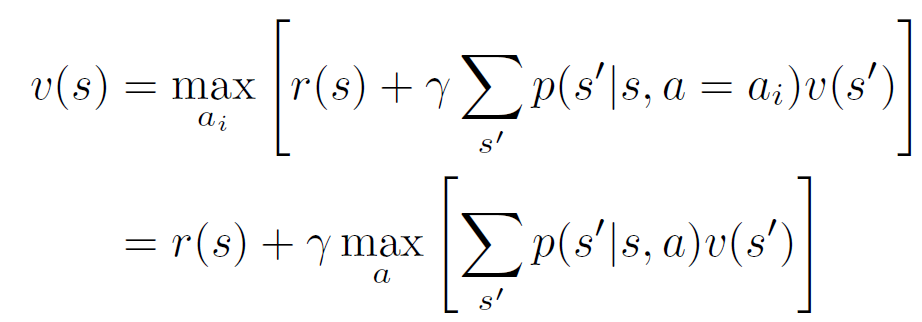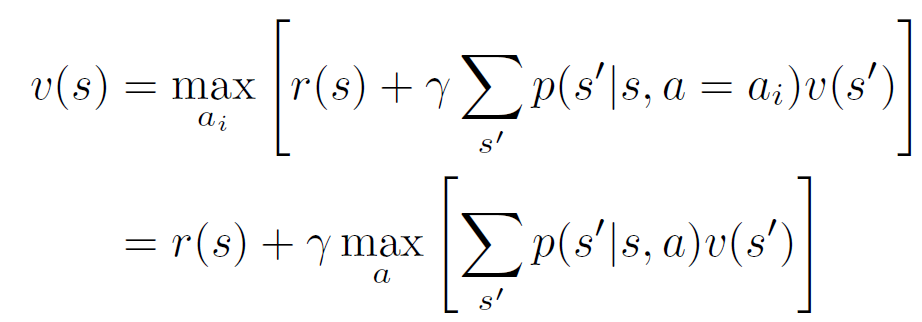ch state.

**Exploration and Exploitation:** By iteratively updating the value function, value iteration balances exploration (searching for better policies) and exploitation (making decisions based on current knowledge). It gradually refines the value function to better approximate the true optimal value function.

#### Mathematical Foundation

**Bellman Optimality Equation:**
\[ V^*(s) = \max_a \sum_{s', r} p(s', r|s, a)[r + \gamma V^*(s')] \]

- \( V^*(s) \) represents the optimal value function for state \( s \), which is the maximum expected cumulative reward achievable from that state.
- \( p(s', r|s, a) \) represents the transition probability and reward function, indicating the probability of transitioning to state \( s' \) and receiving reward \( r \) given the current state \( s \) and action \( a \).
- \( \gamma \) is the discount factor, representing the importance of future rewards relative to immediate rewards.

The equation states that the optimal value of a state is equal to the maximum expected immediate reward plus the discounted maximum expected future reward from the next state.

**Iterative Update Rule:**
\[ V_{k+1}(s) = \max_a \sum_{s', r} p(s', r|s, a)[r + \gamma V_k(s')] \]

- \( V_k(s) \) represents the estimated value function at iteration \( k \).
- \( V_{k+1}(s) \) represents the updated value function at iteration \( k+1 \).

The update rule computes the maximum expected cumulative reward achievable from each state based on the current estimate of the value function \( V_k \).

**Convergence:** Value iteration converges to the optimal value function when the value function stops changing significantly between iterations. The algorithm terminates when the maximum change in the value function falls below a predefined threshold.

Value iteration provides a principled approach to solving MDPs by iteratively refining the estimate of the optimal value function. It is widely used in practice due to its simplicity, efficiency, and theoretical guarantees of convergence to the optimal solution.


In [11]:
import pygame
import numpy as np
import matplotlib.pyplot as plt

# Define colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
GREEN = (0, 150, 0)  # Darker shade of green
RED = (255, 0, 0)
BLUE = (0, 0, 255)

# Gridworld dimensions
n = 5  # Number of rows
m = 5  # Number of columns

# Placeholder grid 
grid = np.array([
    [0, 0, 0, 0, 0],   
    [0, -10, 0, 0, 0],  # Obstacle  cell with -1
    [0, 0, 0, -10, 0],   # Obstacle  cell with -1
    [0, -10, 0, 0, 0],  # Obstacle 'cell with -1
    [0, 0, 0, 0, 10]    # Goal cell with +10 reward
])

# Initialize Pygame
pygame.init()
screen = pygame.display.set_mode((650, 700))  # Set screen size to 650x700 to accommodate log area and wider grid
pygame.display.set_caption("Gridworld Reinforcement Learning")

# Cell size
cell_size = 120  # Increased cell size for better visibility

# Logging
log = []

# Font for text display
font = pygame.font.SysFont('arial', 20)  # Change font to Arial and reduce size for better fit

# Draw log text
log_text = font.render("Log:", True, BLACK)
screen.blit(log_text, (10, n * cell_size + 20))
log_area_height = 150
log_area = pygame.Rect(10, (n * cell_size + 50), 630, log_area_height)  # Define log area rectangle
pygame.draw.rect(screen, WHITE, log_area)  # Draw log area background
for index, entry in enumerate(log[-5:]): # Display only the last 5 log entries
    log_entry = font.render(entry, True, BLACK)
    screen.blit(log_entry, (20, (n * cell_size + 70) + index * 25))

# Define other necessary functions
def draw_gridworld(screen, grid, font, V=None):
    """
    Draws the gridworld on the screen with rewards, values, and log entries.
    """
    n, m = grid.shape

    screen.fill(WHITE)

    for i in range(n):
        for j in range(m):
            pygame.draw.rect(screen, BLACK, (j * cell_size, i * cell_size, cell_size, cell_size), 1)

            if grid[i, j] == -1:
                color = BLACK  # Change the color of obstacles to Black
                pygame.draw.rect(screen, color, (j * cell_size, i * cell_size, cell_size, cell_size))
            elif grid[i, j] == 10:
                color = GREEN
                pygame.draw.rect(screen, color, (j * cell_size, i * cell_size, cell_size, cell_size))
            elif grid[i, j] == 0:
                color = WHITE
            else:
                color = BLUE

            if V is not None:
                value_text = font.render(str(round(V[i, j], 2)), True, BLACK)
                text_rect = value_text.get_rect(center=(j * cell_size + cell_size // 2, i * cell_size + cell_size // 2))
                screen.blit(value_text, text_rect)

            reward_text = font.render(str(grid[i, j]), True, color)
            reward_text_rect = reward_text.get_rect(center=(j * cell_size + cell_size // 2, i * cell_size + cell_size // 2))
            screen.blit(reward_text, reward_text_rect)

def draw_agent(screen, agent_pos, cell_size):
    """
    Draws the agent on the screen.
    """
    pygame.draw.circle(screen, RED, (agent_pos[1] * cell_size + cell_size // 2,
                                     agent_pos[0] * cell_size + cell_size // 2), cell_size // 6)

def get_action_index(action):
    """
    Returns the index corresponding to a given action.
    """
    actions = ['up', 'down', 'left', 'right']
    return actions.index(action)

def get_next_state(grid, state, action):
    """
    Returns the next state after taking an action from the current state,
    handling boundary conditions and obstacles.
    """
    n, m = grid.shape
    potential_states = {
        'up': (max(state[0] - 1, 0), state[1]),
        'down': (min(state[0] + 1, n - 1), state[1]),
        'left': (state[0], max(state[1] - 1, 0)),
        'right': (state[0], min(state[1] + 1, m - 1))
    }
    next_state = potential_states.get(action)
    if next_state is not None and grid[next_state[0], next_state[1]] != '-1' :
        return next_state
    else:
        return None

def get_valid_actions(grid, state):
    """
    Returns a list of valid actions from the given state (considering obstacles and grid boundaries).
    """
    actions = ['up', 'down', 'left', 'right']
    valid_actions = []
    n, m = grid.shape
    for action in actions:
        new_pos = get_next_state(grid, state, action)
        if new_pos is not None and 0 <= new_pos[0] < n and 0 <= new_pos[1] < m:
            valid_actions.append(action)
    return valid_actions

def value_iteration(grid, gamma=0.9, threshold=1e-6, max_iter=1000):
    """
    Perform value iteration to compute the optimal value function and policy for the given gridworld.
    """
    n, m = grid.shape
    num_actions = 4
    V = np.zeros((n, m))

    for _ in range(max_iter):
        delta = 0
        for i in range(n):
            for j in range(m):
                if grid[i, j] == '-1' or grid[i, j] == '1':
                    continue
                v = V[i, j]
                valid_actions = get_valid_actions(grid, (i, j))  # Get valid actions for the current state
                action_values = np.zeros(num_actions)
                for action in valid_actions:  # Iterate over valid actions only
                    new_pos = get_next_state(grid, (i, j), action)
                    if new_pos is not None:
                        reward = grid[new_pos[0], new_pos[1]]
                        action_values[get_action_index(action)] = reward + gamma * V[new_pos[0], new_pos[1]]
                V[i, j] = np.max(action_values)
                delta = max(delta, abs(v - V[i, j]))
        if delta < threshold:
            break

    policy = np.zeros((n, m), dtype=int)
    for i in range(n):
        for j in range(m):
            if grid[i, j] == '-1' or grid[i, j] == '1':
                continue
            valid_actions = get_valid_actions(grid, (i, j))  # Get valid actions for the current state
            action_values = np.zeros(num_actions)
            for action in valid_actions:  # Iterate over valid actions only
                new_pos = get_next_state(grid, (i, j), action)
                if new_pos is not None:
                    reward = grid[new_pos[0], new_pos[1]]
                    action_values[get_action_index(action)] = reward + gamma * V[new_pos[0], new_pos[1]]
            policy[i, j] = get_action_index(valid_actions[np.argmax(action_values)])  # Get action index

    return V, policy

# Main function
def main():
    clock = pygame.time.Clock()

    V, policy = value_iteration(grid)

    agent_pos = (0, 0)
    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Choose action based on policy
        action_index = policy[agent_pos[0], agent_pos[1]]
        action = ['up', 'down', 'left', 'right'][action_index]

        # Update agent's position
        new_pos = get_next_state(grid, agent_pos, action)
        if new_pos is not None:
            agent_pos = new_pos
            log.append(f"Agent moved to position: {new_pos}")

        # Update log text
        screen.fill((255, 255, 255))
        draw_gridworld(screen, grid, font, V)
        
        # Draw agent at updated position
        draw_agent(screen, agent_pos, 120)
        
        # Print log details for debugging
        log.append(f"Agent position: {agent_pos}")
        log.append(f"Value function at agent's position: {V[agent_pos[0], agent_pos[1]]}")

        # Update log text
        log_text = font.render("Log:", True, BLACK)
        screen.blit(log_text, (10, n * cell_size + 20))
        log_area_height = 150
        log_area = pygame.Rect(10, (n * cell_size + 50), 630, log_area_height)
        pygame.draw.rect(screen, WHITE, log_area)
        for index, entry in enumerate(log[-5:]):
            log_entry = font.render(entry, True, BLACK)
            screen.blit(log_entry, (20, (n * cell_size + 70) + index * 25))
        
        # Print log details for debugging
        print("\\n\n\nLog details:", log)

        # Update display
        pygame.display.flip()
        
        # Control frame rate
        clock.tick(10)

    pygame.quit()

# Call the main function

main()


\n

Log details: ['Agent moved to position: (1, 0)', 'Agent position: (1, 0)', "Value function at agent's position: 53.144091018550085"]
\n

Log details: ['Agent moved to position: (1, 0)', 'Agent position: (1, 0)', "Value function at agent's position: 53.144091018550085", 'Agent moved to position: (2, 0)', 'Agent position: (2, 0)', "Value function at agent's position: 59.04899101855009"]
\n

Log details: ['Agent moved to position: (1, 0)', 'Agent position: (1, 0)', "Value function at agent's position: 53.144091018550085", 'Agent moved to position: (2, 0)', 'Agent position: (2, 0)', "Value function at agent's position: 59.04899101855009", 'Agent moved to position: (3, 0)', 'Agent position: (3, 0)', "Value function at agent's position: 65.60999101855008"]
\n

Log details: ['Agent moved to position: (1, 0)', 'Agent position: (1, 0)', "Value function at agent's position: 53.144091018550085", 'Agent moved to position: (2, 0)', 'Agent position: (2, 0)', "Value function at agent's position: 

# Single-State Multi-Armed Bandit Problem Definition


<p><strong>Environment:</strong><br>
The environment is a single-state, multi-armed bandit problem with a single state.<br>
There are multiple arms (actions) available for the agent to choose from, typically denoted as K arms (e.g., 𝐾=10 arms).</p>
<p><strong>Agent:</strong><br>
The agent's goal is to maximize the total reward it accumulates over a fixed number of time steps by selecting the best arms to pull.<br>
The agent must balance exploration (trying new arms to find better rewards) and exploitation (choosing arms with known high rewards).</p>
<p><strong>Actions:</strong><br>
The agent can take one of 𝐾 actions at each time step, where each action corresponds to pulling one of the K arms.<br>
Once an arm is pulled, the agent receives a reward and observes the outcome.</p>
<p><strong>Rewards:</strong><br>
Each arm has a reward distribution that determines the reward received when the arm is pulled.<br>
The rewards are stochastic (random) and follow a specific distribution (e.g., normal distribution, Bernoulli distribution).<br>
The mean reward and variance of each arm's distribution may be unknown to the agent initially.</p>
<p><strong>Objective:</strong><br>
The agent's objective is to maximize the total cumulative reward it receives over a fixed number of time steps 𝑁.<br>
The agent must learn which arms provide the highest expected rewards while also exploring less-known arms.</p>
<p><strong>Initial Conditions:</strong><br>
The agent starts with no prior knowledge of the arms' reward distributions.<br>
The agent can keep track of the estimated mean reward for each arm based on its past observations.</p>
<p><strong>Evaluation:</strong><br>
At the end of the experiment, evaluate the agent's performance based on the total cumulative reward it received over 𝑁 time steps.<br>
Compare the agent's strategy with the optimal strategy (if known) and observe how closely the agent approached the optimal cumulative reward.</p>

<h2>Environment</h2>
<p>Gym of OpenAI - <a href="https://gymnasium.farama.org">https://gymnasium.farama.org</a><br>
Use FrozenLake-v1 of OpenAI Gym as a Gridworld environment</p>
